### This notebook focusses on :
* fetching a textfile (csv format) from HDFS
* perform minor data wrangling activity
* save it back to HDFS as Parquet and AVRO format

##### Install Apache Avro
* as mentioned in : http://avro.apache.org/docs/current/gettingstartedpython.html

In [1]:
import avro.schema
from avro.datafile import DataFileReader, DataFileWriter
from avro.io import DatumReader, DatumWriter

In [2]:
#panda devo bhava
import pandas as pd

##### Simplest way of reading a text file from HDFS and displaying its content
* Note that HDFS AWS location can be found at
    * AWS Cluster summary page --> click/open resource manager --> click on Tools --> configuration --> it opens up an xml file --> search for "hdfs://"

In [3]:
from pyspark import SparkContext
sc = SparkContext(appName="Avro")
file = sc.textFile(r"hdfs://ip-172-31-34-205.us-east-2.compute.internal:8020/user/ec2-user/temp.csv")
file.collect()

[" MP Constituency ,Assembly,Ward No,Ward Name ,Winning candidate,Winner's party,Past corporator Party",
 'Bangalore South,B.T.M. Layout,146,Lakkasandra,Mahesh Babu,BJP,BJP',
 'Bangalore South,B.T.M. Layout,147,Adugodi,Manjula,INC,INC',
 'Bangalore South,B.T.M. Layout,148,Ejipura,T Ramachandra,INC,INC',
 'Bangalore South,B.T.M. Layout,151,Koramangala,M Chandrappa,INC,INC',
 'Bangalore South,B.T.M. Layout,152,Suddugunte Palya,G Manjunath,INC,INC',
 'Bangalore South,B.T.M. Layout,172,Madiwala,B N Manjunath Reddy,INC,INC',
 'Bangalore South,B.T.M. Layout,173,Jakkasandra,Saraswathamma,BJP,BJP',
 'Bangalore South,B.T.M. Layout,176,B.T.M.Layout,K Devadas,JDS,INC',
 "Bangalore South,Bangalore South,184,Uttarahalli,Hanumantaiah',BJP,BJP",
 'Bangalore South,Bangalore South,185,Yelachenahalli,V Balakrishna,BJP,INC',
 'Bangalore South,Bangalore South,192,Begur,M Anjinappa,INC,JDS',
 'Bangalore South,Bangalore South,194,Gottigere,Lalitha T Narayan,BJP,INC',
 'Bangalore South,Bangalore South,195,Ko

This is fine but we need data to be processed and hence we need structured access to this raw data.

##### Let us use SQLContext to load data into dataframe
* Note that sqlcontext requires sparkcontext as input.

In [6]:
from pyspark.sql import SQLContext
sqlContext = SQLContext(sc)

Note that "hdfs://..." was not required in case you are accessing files through HUE. This is becauase HUE login itself moves to you that URL. So it is relative to that location. However, though notebook is launched in that location it is ultimately the program trying to access the file with no env support. Jupyter does provide the python and anaconda env/packages but not HDFS. 

In [7]:
df = sqlContext.read.csv('hdfs://ip-172-31-34-205.us-east-2.compute.internal:8020/user/ec2-user/temp.csv',header=True)

In [30]:
df.show()

+-----------------+---------------+-------+----------------+--------------------+--------------+---------------------+
| MP Constituency |       Assembly|Ward No|      Ward Name |   Winning candidate|Winner's party|Past corporator Party|
+-----------------+---------------+-------+----------------+--------------------+--------------+---------------------+
|  Bangalore South|  B.T.M. Layout|    146|     Lakkasandra|         Mahesh Babu|           BJP|                  BJP|
|  Bangalore South|  B.T.M. Layout|    147|         Adugodi|             Manjula|           INC|                  INC|
|  Bangalore South|  B.T.M. Layout|    148|         Ejipura|       T Ramachandra|           INC|                  INC|
|  Bangalore South|  B.T.M. Layout|    151|     Koramangala|        M Chandrappa|           INC|                  INC|
|  Bangalore South|  B.T.M. Layout|    152|Suddugunte Palya|         G Manjunath|           INC|                  INC|
|  Bangalore South|  B.T.M. Layout|    172|     

In [9]:
type(df)

pyspark.sql.dataframe.DataFrame

##### Convert HDFS Dataframe to Python Panda DateFrame

In [10]:
pdf = df.toPandas()

In [77]:
type(pdf), pdf.shape

(pandas.core.frame.DataFrame, (199, 7))

In [12]:
#let us slice in panda style
pdf[pdf['Winning candidate'] == 'Manjula']

,MP Constituency,Assembly,Ward No,Ward Name,Winning candidate,Winner's party,Past corporator Party
1,Bangalore South,B.T.M. Layout,147,Adugodi,Manjula,INC,INC


##### Data Wrangling
* change the column name to programmer friendly
    * it is also requirement to parquet storage

In [50]:
for c in pdf.columns:
    pdf = pdf.rename(index=str,columns={c:c.strip().replace(" ","_").replace("'","").lower()})
pdf.head()

,mp_constituency,assembly,ward_no,ward_name,winning_candidate,winners_party,past_corporator_party
0,Bangalore South,B.T.M. Layout,146,Lakkasandra,Mahesh Babu,BJP,BJP
1,Bangalore South,B.T.M. Layout,147,Adugodi,Manjula,INC,INC
2,Bangalore South,B.T.M. Layout,148,Ejipura,T Ramachandra,INC,INC
3,Bangalore South,B.T.M. Layout,151,Koramangala,M Chandrappa,INC,INC
4,Bangalore South,B.T.M. Layout,152,Suddugunte Palya,G Manjunath,INC,INC


##### Quick view into the data

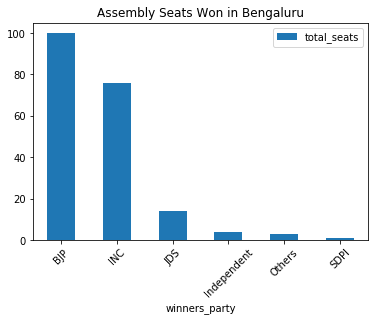

In [49]:
pdf.groupby([ 'winners_party' ]).\
    agg("count").\
    reset_index()[[ 'winners_party', 'ward_name']].\
    rename(index=str, columns={"ward_name":"total_seats"}).\
    sort_values("total_seats", ascending=False).\
    plot.bar("winners_party","total_seats", rot=45, title= "Assembly Seats Won in Bengaluru" );

##### To save the file in parquet format locally (inside master node - linux system)
* Note that parquet format saving require pyarrow to be installed - conda install pyarrow

In [55]:
pdf.to_parquet("parquet")

##### Facing issue to save from pandas to HDFS file but we have a work around

In [16]:
pdf.to_parquet("hdfs://ip-172-31-34-205.us-east-2.compute.internal:8020/user/ec2-user/parquet")

ArrowIOError: Unable to load libhdfs

##### Convert the pandas back to spark dataframe

In [56]:
df = sqlContext.createDataFrame(pdf)

In [69]:
!hadoop fs -rm -R parquet

rm: `parquet': No such file or directory


In [70]:
df.write.parquet("hdfs://ip-172-31-34-205.us-east-2.compute.internal:8020/user/ec2-user/parquet")

In [71]:
!hadoop fs -ls parquet

Found 9 items
-rw-r--r--   3 ec2-user ec2-user          0 2019-04-30 16:27 parquet/_SUCCESS
-rw-r--r--   3 ec2-user ec2-user       2891 2019-04-30 16:27 parquet/part-00000-8dea8443-ed6b-4be8-b442-311df48e4f60-c000.snappy.parquet
-rw-r--r--   3 ec2-user ec2-user       2914 2019-04-30 16:27 parquet/part-00001-8dea8443-ed6b-4be8-b442-311df48e4f60-c000.snappy.parquet
-rw-r--r--   3 ec2-user ec2-user       2929 2019-04-30 16:27 parquet/part-00002-8dea8443-ed6b-4be8-b442-311df48e4f60-c000.snappy.parquet
-rw-r--r--   3 ec2-user ec2-user       2945 2019-04-30 16:27 parquet/part-00003-8dea8443-ed6b-4be8-b442-311df48e4f60-c000.snappy.parquet
-rw-r--r--   3 ec2-user ec2-user       2880 2019-04-30 16:27 parquet/part-00004-8dea8443-ed6b-4be8-b442-311df48e4f60-c000.snappy.parquet
-rw-r--r--   3 ec2-user ec2-user       2970 2019-04-30 16:27 parquet/part-00005-8dea8443-ed6b-4be8-b442-311df48e4f60-c000.snappy.parquet
-rw-r--r--   3 ec2-user ec2-user       2865 2019-04-30 16:27 parquet/part-00006-8dea84

In [81]:
print(
2891
+2914
+2929
+2945
+2880
+2970
+2865
+3127)

23521


In [79]:
!hadoop fs -ls temp.csv

-rw-r--r--   1 ec2-user ec2-user      14384 2019-04-30 12:08 temp.csv


##### Note that here the total parquet is more than that of the raw file because of partitioning. 

##### However, parquet does compress the files and we can see this observation as indicate below.
* Here temp.csv is the raw file and parquet is the pandas.to_parquet output (local) file

In [83]:
!ls -l temp.csv parquet

-rw-rw-r-- 1 ec2-user ec2-user 11142 Apr 30 16:20 parquet
-rw-r--r-- 1 ec2-user ec2-user 14384 Apr 30 12:59 temp.csv


##### Let us Double check the save parquet file size for correctness

In [76]:
new_df = sqlContext.read.parquet('hdfs://ip-172-31-34-205.us-east-2.compute.internal:8020/user/ec2-user/parquet')
print("Shape :", new_df.toPandas().shape)
new_df.toPandas().head()

Shape : (199, 7)


,mp_constituency,assembly,ward_no,ward_name,winning_candidate,winners_party,past_corporator_party
0,Bangalore Central,Shanthi Nagar,111,Shantala Nagar,M B Dwarakanath,BJP,Independent
1,Bangalore Central,Shanthi Nagar,112,Dommalur,Lakshminarayan,Others,BJP
2,Bangalore Central,Shanthi Nagar,114,Agaram,Bhavya,BJP,INC
3,Bangalore Central,Shanthi Nagar,115,Vannarpete,K Shivakumar,BJP,INC
4,Bangalore Central,Shanthi Nagar,116,Neelasandra,Balakrishnan G,INC,INC


##### Conver the panda to avro

In [118]:
import os
os.environ['PYSPARK_SUBMIT_ARGS'] = '--packages org.apache.spark:spark-avro_2.12:2.4.2 pyspark-shell'

In [119]:
sc.stop()
sc =SparkContext(appName="avro")
sqlContext = SQLContext(sc)
new_df = sqlContext.read.parquet('hdfs://ip-172-31-34-205.us-east-2.compute.internal:8020/user/ec2-user/parquet')
print("Shape :", new_df.toPandas().shape)
new_df.toPandas().head()

Shape : (199, 7)


,mp_constituency,assembly,ward_no,ward_name,winning_candidate,winners_party,past_corporator_party
0,Bangalore Central,Shanthi Nagar,111,Shantala Nagar,M B Dwarakanath,BJP,Independent
1,Bangalore Central,Shanthi Nagar,112,Dommalur,Lakshminarayan,Others,BJP
2,Bangalore Central,Shanthi Nagar,114,Agaram,Bhavya,BJP,INC
3,Bangalore Central,Shanthi Nagar,115,Vannarpete,K Shivakumar,BJP,INC
4,Bangalore Central,Shanthi Nagar,116,Neelasandra,Balakrishnan G,INC,INC


In [121]:
new_df.write.format("org.apache.spark::spark-avro").save("avro")

Py4JJavaError: An error occurred while calling o460.save.
: java.lang.ClassNotFoundException: Failed to find data source: org.apache.spark::spark-avro. Please find packages at http://spark.apache.org/third-party-projects.html
	at org.apache.spark.sql.execution.datasources.DataSource$.lookupDataSource(DataSource.scala:657)
	at org.apache.spark.sql.DataFrameWriter.save(DataFrameWriter.scala:244)
	at org.apache.spark.sql.DataFrameWriter.save(DataFrameWriter.scala:228)
	at sun.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at sun.reflect.NativeMethodAccessorImpl.invoke(NativeMethodAccessorImpl.java:62)
	at sun.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.lang.reflect.Method.invoke(Method.java:498)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:357)
	at py4j.Gateway.invoke(Gateway.java:282)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.GatewayConnection.run(GatewayConnection.java:238)
	at java.lang.Thread.run(Thread.java:748)
Caused by: java.lang.ClassNotFoundException: org.apache.spark::spark-avro.DefaultSource
	at java.net.URLClassLoader.findClass(URLClassLoader.java:382)
	at java.lang.ClassLoader.loadClass(ClassLoader.java:424)
	at java.lang.ClassLoader.loadClass(ClassLoader.java:357)
	at org.apache.spark.sql.execution.datasources.DataSource$$anonfun$20$$anonfun$apply$12.apply(DataSource.scala:634)
	at org.apache.spark.sql.execution.datasources.DataSource$$anonfun$20$$anonfun$apply$12.apply(DataSource.scala:634)
	at scala.util.Try$.apply(Try.scala:192)
	at org.apache.spark.sql.execution.datasources.DataSource$$anonfun$20.apply(DataSource.scala:634)
	at org.apache.spark.sql.execution.datasources.DataSource$$anonfun$20.apply(DataSource.scala:634)
	at scala.util.Try.orElse(Try.scala:84)
	at org.apache.spark.sql.execution.datasources.DataSource$.lookupDataSource(DataSource.scala:634)
	... 13 more


In [108]:
import com.databricks.spark.avro._

ModuleNotFoundError: No module named 'com'

In [107]:
new_df.write.format("com.databricks.spark.avro").save("avro")

Py4JJavaError: An error occurred while calling o240.save.
: java.lang.ClassNotFoundException: Failed to find data source: org.apache.spark.sql.avro.AvroFileFormat. Please find packages at http://spark.apache.org/third-party-projects.html
	at org.apache.spark.sql.execution.datasources.DataSource$.lookupDataSource(DataSource.scala:657)
	at org.apache.spark.sql.DataFrameWriter.save(DataFrameWriter.scala:244)
	at org.apache.spark.sql.DataFrameWriter.save(DataFrameWriter.scala:228)
	at sun.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at sun.reflect.NativeMethodAccessorImpl.invoke(NativeMethodAccessorImpl.java:62)
	at sun.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.lang.reflect.Method.invoke(Method.java:498)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:357)
	at py4j.Gateway.invoke(Gateway.java:282)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.GatewayConnection.run(GatewayConnection.java:238)
	at java.lang.Thread.run(Thread.java:748)
Caused by: java.lang.ClassNotFoundException: org.apache.spark.sql.avro.AvroFileFormat.DefaultSource
	at java.net.URLClassLoader.findClass(URLClassLoader.java:382)
	at java.lang.ClassLoader.loadClass(ClassLoader.java:424)
	at java.lang.ClassLoader.loadClass(ClassLoader.java:357)
	at org.apache.spark.sql.execution.datasources.DataSource$$anonfun$20$$anonfun$apply$12.apply(DataSource.scala:634)
	at org.apache.spark.sql.execution.datasources.DataSource$$anonfun$20$$anonfun$apply$12.apply(DataSource.scala:634)
	at scala.util.Try$.apply(Try.scala:192)
	at org.apache.spark.sql.execution.datasources.DataSource$$anonfun$20.apply(DataSource.scala:634)
	at org.apache.spark.sql.execution.datasources.DataSource$$anonfun$20.apply(DataSource.scala:634)
	at scala.util.Try.orElse(Try.scala:84)
	at org.apache.spark.sql.execution.datasources.DataSource$.lookupDataSource(DataSource.scala:634)
	... 13 more


In [96]:
new_pdf = new_df.toPandas()


In [103]:

    print(dict(r))
    break

{'mp_constituency': 'Bangalore Central', 'assembly': 'Shanthi Nagar', 'ward_no': '111', 'ward_name': 'Shantala Nagar', 'winning_candidate': 'M B Dwarakanath', 'winners_party': 'BJP', 'past_corporator_party': 'Independent'}


In [106]:
schema = avro.schema.parse(open("election.avsc", "rb").read())

writer = DataFileWriter(open("election.avro", "wb"), DatumWriter(), schema)
for idx, r in new_pdf.iterrows():
    writer.append(dict(r))
writer.close()

AttributeError: module 'avro.schema' has no attribute 'parse'